In [2]:
from pandas import read_csv
from datetime import datetime

#load data
def parse(x):
  return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('raw.csv', parse_dates=[['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)

#manually specify column names
dataset.columns = ['pm2.5', 'dew', 'temp', 'press','wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
cols = dataset.columns.tolist()
cols = ['temp','pm2.5', 'dew','press','wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset = dataset[cols]


#mark all NA values with 0
dataset['pm2.5'].fillna(0, inplace=True)

#drop the first 24 hours
dataset = dataset[24:]

#summarize first 5 rows
print(dataset.head(5))

#save to file
dataset.to_csv('temp.csv')


                     temp  pm2.5  dew   press wnd_dir  wnd_spd  snow  rain
date                                                                      
2010-01-02 00:00:00  -4.0  129.0  -16  1020.0      SE     1.79     0     0
2010-01-02 01:00:00  -4.0  148.0  -15  1020.0      SE     2.68     0     0
2010-01-02 02:00:00  -5.0  159.0  -11  1021.0      SE     3.57     0     0
2010-01-02 03:00:00  -5.0  181.0   -7  1022.0      SE     5.36     1     0
2010-01-02 04:00:00  -5.0  138.0   -7  1022.0      SE     6.25     2     0


In [3]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


<Figure size 432x288 with 0 Axes>

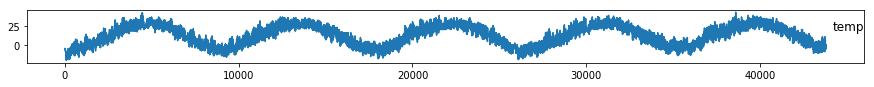

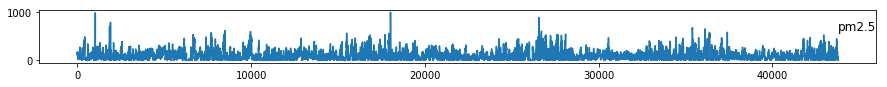

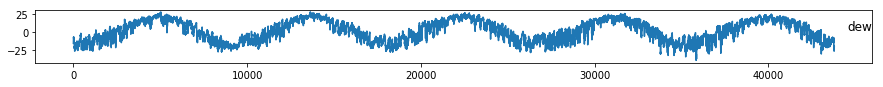

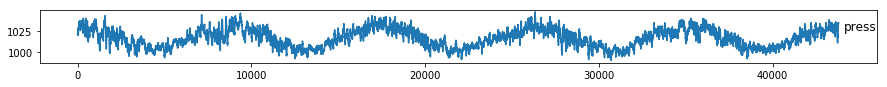

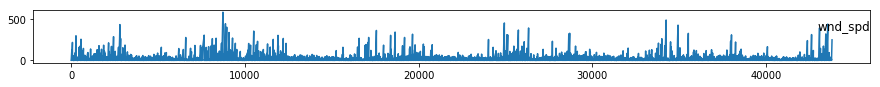

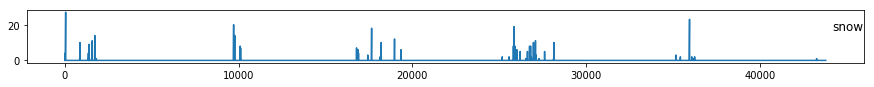

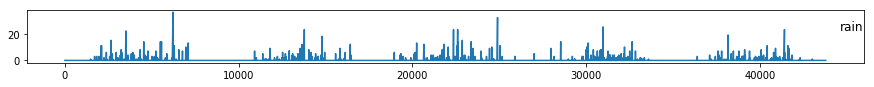

In [4]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('temp.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.figure(figsize=(15,8))
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

In [5]:
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
import pandas


# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df =pandas.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pandas.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
dataset = read_csv('temp.csv', header=0, index_col=0)
values = dataset.values


# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed)

       var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1       0.245902   0.129779   0.352941   0.527273   0.666667   0.002290   
2       0.245902   0.148893   0.367647   0.527273   0.666667   0.003811   
3       0.229508   0.159960   0.426471   0.545454   0.666667   0.005332   
4       0.229508   0.182093   0.485294   0.563637   0.666667   0.008391   
5       0.229508   0.138833   0.485294   0.563637   0.666667   0.009912   
6       0.213115   0.109658   0.485294   0.563637   0.666667   0.011433   
7       0.213115   0.105634   0.485294   0.581818   0.666667   0.014492   
8       0.229508   0.124748   0.485294   0.600000   0.666667   0.017551   
9       0.213115   0.120724   0.470588   0.600000   0.666667   0.020610   
10      0.229508   0.132797   0.485294   0.618183   0.666667   0.023669   
11      0.229508   0.140845   0.485294   0.636364   0.666667   0.029018   
12      0.229508   0.152918   0.470588   0.636364   0.666667   0.034367   
13      0.229508   0.1488

In [6]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 8760 samples, validate on 35039 samples
Epoch 1/50
 - 6s - loss: 0.0902 - val_loss: 0.2334
Epoch 2/50
 - 2s - loss: 0.0772 - val_loss: 0.2134
Epoch 3/50
 - 2s - loss: 0.0680 - val_loss: 0.1999
Epoch 4/50
 - 2s - loss: 0.0617 - val_loss: 0.1885
Epoch 5/50
 - 2s - loss: 0.0565 - val_loss: 0.1790
Epoch 6/50
 - 2s - loss: 0.0521 - val_loss: 0.1716
Epoch 7/50
 - 2s - loss: 0.0480 - val_loss: 0.1662
Epoch 8/50
 - 2s - loss: 0.0445 - val_loss: 0.1601
Epoch 9/50
 - 2s - loss: 0.0410 - val_loss: 0.1550
Epoch 10/50
 - 2s - loss: 0.0377 - val_loss: 0.1504
Epoch 11/50
 - 2s - loss: 0.0342 - val_loss: 0.1452
Epoch 12/50
 - 2s - loss: 0.0312 - val_loss: 0.1377
Epoch 13/50
 - 2s - loss: 0.0283 - val_loss: 0.1302
Epoch 14/50
 - 2s - loss: 0.0262 - val_loss: 0.1218
Epoch 15/50
 - 2s - loss: 0.0244 - val_loss: 0.1170
Epoch 16/50
 - 2s - loss: 0.0234 - val_loss: 0.1138
Epoch 17

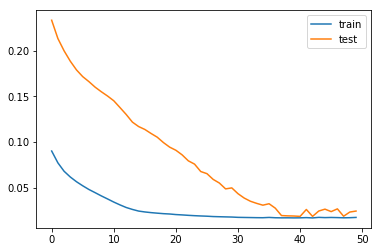

In [7]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), 
                    verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [8]:
 # make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.888


In [ ]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

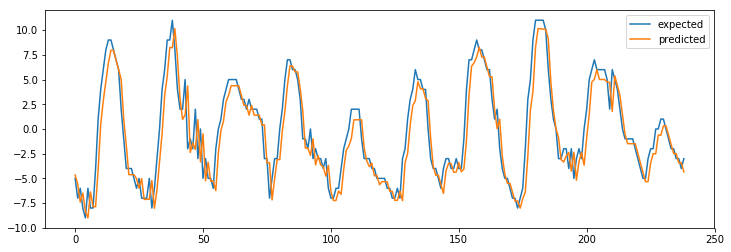

In [10]:
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot

# line plot of observed vs predicted
pyplot.figure(figsize=(12,4))
#pyplot.legend(loc='upper right')
pyplot.plot(inv_y[34800:], label='expected')
pyplot.plot(inv_yhat[34800:], label='predicted')
pyplot.legend(loc='upper right')
pyplot.show()

In [66]:
print(inv_y[35000:])



[ 1.9999995  5.         6.0000005  6.9999995  6.0000005  6.0000005
  6.0000005  6.0000005  5.         1.9999995  6.0000005  5.
  3.999999   1.9999995  0.        -1.0000007 -1.0000007 -1.0000007
 -1.0000007 -1.9999995 -3.0000002 -4.        -5.        -5.
 -3.0000002 -1.9999995 -1.9999995  0.         0.         1.0000007
  1.0000007  0.        -1.0000007 -1.9999995 -1.9999995 -3.0000002
 -3.0000002 -4.        -3.0000002]


In [67]:
print(inv_yhat[35000:])

[-0.58163047  1.647357    4.827866    5.2539463   6.2221546   5.2299876
  5.2403097   5.244489    5.0962563   4.7832937   1.8426713   5.5520015
  4.544318    3.552349    1.5109622  -0.4462629  -1.3784689  -1.3828356
 -1.3840336  -1.3871386  -2.3709087  -3.3378048  -4.3213367  -5.270936
 -5.2673664  -3.3930519  -2.4488986  -2.4531214  -0.5562575  -0.5952832
  0.35252437  0.3584963  -0.555603   -1.4963261  -2.4334404  -2.4503129
 -3.3731418  -3.3716857  -4.2942457 ]
